In [1]:
# David R Thompson
using Printf
using DelimitedFiles
using LinearAlgebra
using Plots
using Statistics
using SpecialFunctions: erf

# Parse ENVI header
function parse_envi_header(filename::AbstractString)::Dict{String, String}
    header_dict = Dict{String, String}()
    # Open the file
    open(filename, "r") do file
        for line in eachline(file)
            if strip(line) == "ENVI"
                continue
            end
            # Split the line into key-value pairs
            key, value = split(line, "=", limit=2)
            # Remove leading/trailing whitespaces
            key = strip(key)
            value = strip(value)
            # Store the key-value pair in the dictionary
            header_dict[key] = value
        end
    end
    return header_dict
end

# Helper function to parse wavelengths, fwhms 
function parse_header_vector(header_dict::Dict{String, String}, keyname::String)::Vector{Float64}
    str = header_dict[keyname]
    str = replace(replace(replace(str,"{" => ""), "}" => ""))
    return parse.(Float64,split(str, ","))
end

# Gaussian spectral response
function spectral_response_function(response_range::Array{Float64,1}, mu::Float64, sigma::Float64)::Array{Float64,1}
    u = (response_range .- mu) ./ abs(sigma)
    y = (1.0 ./ (sqrt(2.0 * π) .* abs(sigma))) .* exp.(-u .* u ./ 2.0)
    srf = y ./ sum(y)
    return srf
end

# Apply new sampling
function resample_spectrum(x::Array{Float64,1}, wl::Array{Float64,1}, wl2::Array{Float64,1}, fwhm2::Array{Float64,1}, fill::Bool = false
)::Array{Float64,1}
    H = [spectral_response_function(wl, wi, fwhmi / 2.355) for (wi, fwhmi) in zip(wl2, fwhm2)]
    if !fill
        return H * x
    else
        xnew = H * x
        good = isfinite.(xnew)
        for i in 1:length(xnew)
            if !good[i]
                nearest_good_ind = argmin(abs.(wl2[good] .- wl2[i]))
                xnew[i] = xnew[nearest_good_ind]
            end
        end
        return xnew
    end
end

# -------------------- Conditional Gaussian

function conditional_gaussian(
        mu::Vector{T}, 
        sigma::Matrix{T}, 
        indices_observe::Vector{Int}, 
        indices_infer::Vector{Int},
        x::Vector{T}
    ) where T<:AbstractFloat
    
    # Partitioning the mean vector and covariance matrix
    mu_observe = mu[indices_observe]
    mu_infer = mu[indices_infer]

    sigma_observe_observe = sigma[indices_observe, indices_observe]
    sigma_infer_infer = sigma[indices_infer, indices_infer]
    sigma_observe_infer = sigma[indices_observe, indices_infer]
    sigma_infer_observe = sigma[indices_infer, indices_observe]

    # Calculate conditional mean and covariance
    mu_conditional = mu_infer .+ sigma_infer_observe * inv(sigma_observe_observe) * (x - mu_observe)
    sigma_conditional = sigma_infer_infer - sigma_infer_observe * inv(sigma_observe_observe) * sigma_observe_infer

    return mu_conditional, sigma_conditional
end

# -------------------- Blackbody Emission

k          = 1.380648e-23    # Boltzmann constant, J K-1
q          = 1.60217733e-19  # elementary charge, in Coulombs
c_1        = 1.88365e32/π # first rad. constant, photon radiance
c_2        = 14387690        # second radiometric constant
c_1watt    = 3.7417749e16/π # first radiometric constant for W/cm2/sr/nm
hc         = 1.986e-16 # J nm

# Black body emitted radiance in uW sr-1 cm-2 nm-1
function planck(emissivity::Vector{Float64}, T::Float64, wl::Vector{Float64})::Vector{Float64}
    # Radiance of a surface due to emission
    c_1 = 1.88365e32/π
    c_2 = 14387690
    J_per_eV = 1.60218e-19
    wl_um = wl / 1000.0
    ph_per_sec_cm2_sr_nm = c_1./(wl.^4)./(exp.(c_2./wl./T).-1.0) .* emissivity
    # photon energy in eV
    eV_per_sec_cm2_sr_nm = 1.2398 .* ph_per_sec_cm2_sr_nm./wl_um
    W_per_cm2_sr_nm = J_per_eV .* eV_per_sec_cm2_sr_nm
    uW_per_cm2_sr_nm = W_per_cm2_sr_nm.*1e6
    return uW_per_cm2_sr_nm
end;

In [2]:

# -------------------- Example Image and Wavelengths

using ArchGDAL
infile = "example/hi07122919_1005000_r"
dataset = ArchGDAL.read(infile)
metadata = parse_envi_header(infile*".hdr")
wl = parse_header_vector(metadata,"wavelength")
fwhm = parse_header_vector(metadata,"fwhm")
irr = parse_header_vector(metadata,"irradiance_1AU")

X = ArchGDAL.read(dataset)
X = X ./ 10 # translate W/(m^2*sr*um) to uW/(cm^2*sr*nm). 1e6/1e4/1e3
use = findall(1100 .<= wl .<= 3600)
use = use[1:3:end]
X = X[:,:,use]
wl = wl[use]
fwhm = fwhm[use]
irr = irr[use];


In [3]:
using DelimitedFiles
using Interpolations

# Generate wavelengths from 600 to 3600 with a step of 10
relab_wl = 600:10:3600

# Nonthermal wavelengths used for normalization
nonthermal = (wl.<2500)

# Empty arrays to store rfls and names
rfls = []
names = []
plot()

# Iterate over files in the directory and process them
for fpath in readdir("data/RELAB_CORRECTED")
    
    if !endswith(fpath,".txt")
        continue
    end
    
    # Append file name to names list
    push!(names, basename(fpath))

    # Load data from file
    filename = joinpath("data/RELAB_CORRECTED", fpath)
    D = open(readdlm,filename)
    relab_wl = D[:,1] 
    relab_rfl = D[:,2]

    # Interpolate relab_rfl to match wl
    interp = Interpolations.linear_interpolation(relab_wl, relab_rfl, extrapolation_bc=Line()) 
    rfl_resamp = interp(wl)
    
    # Append the resampled rfl to rfls
    push!(rfls, rfl_resamp)
end

# Convert rfls to a 2D array
rfls = hcat(rfls...)
# Regularizer
regularizer = 1e-3

# Compute mean and covariance
musurf = vec(mean(rfls, dims=2))
Csurf = cov(rfls, dims=2) + I * regularizer;


In [4]:
using Optim
using ForwardDiff
using BlockDiagonals

# Transform state variables to state vector
function pack(rfl::Vector{Float64}, T::Float64, alpha::Float64)::Vector{Float64}
    return [rfl T alpha]
end

function unpack(x)::Tuple{Vector{Float64},Float64,Float64}
    n = length(x)-2
    rfl = x[1:n]
    T = x[n + 1]
    alpha = x[n + 2]
    return (rfl, T, alpha)
end


function forward(x::Vector{Float64}, wl::Vector{Float64}, irr::Vector{Float64})::Vector{Float64}
    rfl, T, alpha = unpack(x) 
    solar_rdn = rfl .* irr / π
    emissivity = 1 .- rfl
    emiss = planck(emissivity, T, wl)
    return solar_rdn + emiss .* min(alpha,1.0)
end


function error(x::Vector{Float64},wl::Vector{Float64}, irr::Vector{Float64}, rdn::Vector{Float64}, 
        mu::Vector{Float64}, Cinv::Matrix{Float64}, SNR::Float64)::Float64
    mdl = forward(x, wl, irr)
    noise_inv = inv(diagm(rdn ./ SNR))
    cost = (mdl - rdn)' * noise_inv * (mdl - rdn) + (x - mu)' * Cinv * (x - mu)
    return cost
end



function invert(wl::Vector{Float64}, irr::Vector{Float64}, rdn::Vector{Float64}, 
        musurf::Vector{Float64}, Csurf::Matrix{Float64}, SNR::Float64)
    
    rfl_meas = rdn ./ irr .* pi 
    
    indices_observe = findall(wl.<2400)
    indices_infer = findall(wl.>=2400)
    conditional_mean, conditional_Cov = 
      conditional_gaussian(musurf, Csurf, indices_observe, indices_infer, rfl_meas[indices_observe])
    
    C = Matrix(BlockDiagonals.BlockDiagonal([Csurf[indices_infer,indices_infer],[1e9;;],[1e9;;]]))
    Cinv = inv(C)
    mu = [conditional_mean' 350 1.0][1,:]

    res = optimize(x->error(x,wl[indices_infer],irr[indices_infer],rdn[indices_infer],
            mu, Cinv, SNR), mu, BFGS(), Optim.Options(iterations=10000, g_tol = 1e-12))
    best = Optim.minimizer(res)
    rfl_infer, T, alpha = unpack(best)
    rfl_est = copy(rfl_meas)
    rfl_est[indices_infer] = rfl_infer
    return rfl_est, T, alpha
end;

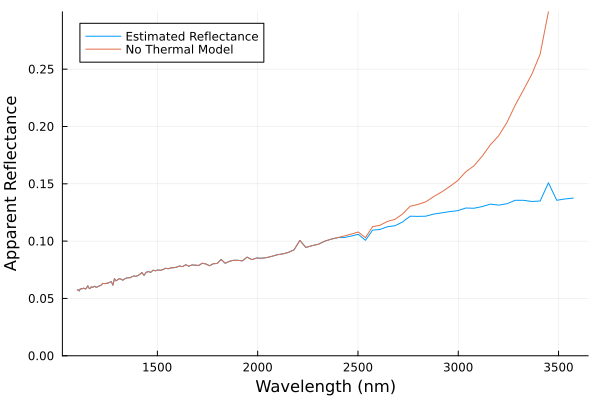

In [5]:
rdn = Vector{Float64}(mean(X,dims=[1,2])[1,1,:])
rdn = Vector{Float64}(X[10,10,:])
rfl_est, T, alpha = invert(wl, irr, rdn, musurf, Csurf, 2000.0) 
rfl_meas = rdn ./ irr .* pi 
mdl = (rfl_est .* irr ./ pi) .+ min(alpha,1.0) .* planck(1.0 .- rfl_est, T, wl)

plot(wl,rfl_est, label="Estimated Reflectance")
plot!(wl,rfl_meas, ylimits=(0,0.3),xlabel=("Wavelength (nm)"),ylabel=("Apparent Reflectance"),
    label="No Thermal Model")

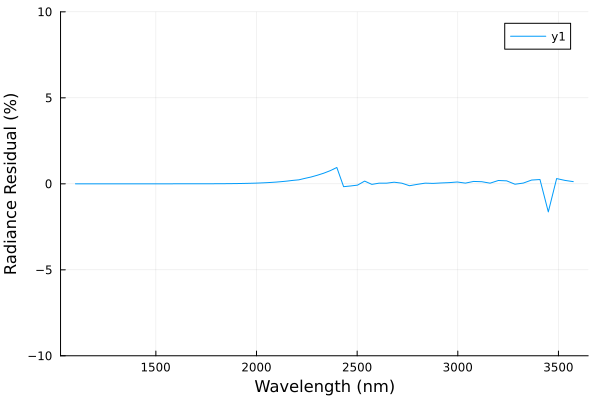

In [6]:
plot(wl,(mdl.-rdn)./rdn*100, ylabel="Radiance Residual (%)", xlabel="Wavelength (nm)", ylimits=(-10,10))


In [24]:
rfls = zero(X)
resids = zero(X)
Ts = zeros(size(X,1),size(X,2),2)

rfl_dataset = ArchGDAL.create(
        "example/out_reflectance", driver=ArchGDAL.getdriver("ENVI"),
        width = size(X,2),
        height = size(X,1),
        nbands = size(X,3),
        dtype = Float64 )
T_dataset = ArchGDAL.create(
        "example/out_temperature", driver=ArchGDAL.getdriver("ENVI"),
        width = size(X,2),
        height = size(X,1),
        nbands = 2,
        dtype = Float64 )
resid_dataset = ArchGDAL.create(
        "example/out_resid", driver=ArchGDAL.getdriver("ENVI"),
        width = size(X,2),
        height = size(X,1),
        nbands = size(X,3),
        dtype = Float64 )

for i in 1:size(X,1)
    println("Row ",i)
    for j in 1:size(X,2)
        rdn = Vector{Float64}(X[i,j,:])
        if median(rdn)<0.1
            continue
        end                
        rfl_est, T, alpha = invert(wl, irr, rdn, musurf, Csurf, 2000.0) 
        rfl_meas = rdn ./ irr .* pi 
        mdl = (rfl_est .* irr ./ pi) .+ min(alpha,1.0) .* planck(1.0 .- rfl_est, T, wl)
        rfls[i,j,:] = rfl_est
        Ts[i,j,1] = T
        Ts[i,j,2] = alpha
        resids[i,j,:] = (mdl.-rdn)./rdn
        
    end
    ArchGDAL.write!(rfl_dataset, rfls, 1:size(rfls,3), 0,0, size(rfls,1), size(rfls,2))
    ArchGDAL.write!(T_dataset, Ts, 1:2, 0,0, size(Ts,1), size(Ts,2))
    ArchGDAL.write!(resid_dataset, resids, 1:size(rfls,3), 0,0, size(rfls,1), size(rfls,2))
end

Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
